In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as creature
import matplotlib.path as mpath
import cmocean as co
import cartopy.mpl.ticker as cticker
import seaborn as sns
import matplotlib.ticker as mticker

theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [2]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/mesh_mask.nc')
route = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/routefile.nc')
dom = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/domain_cfg_orig.nc')
dom_newisf = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/domain_cfg_newisf.nc')
draft = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/shelf_draft.nc')
calv_orig = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/orig_calving.nc')
calv_update = xr.open_dataset('/gws/nopw/j04/terrafirma/nicdet/explore/updated_calving.nc')


In [3]:
prefix = calv_orig.keys()
calv_orig['soicbclv'] = calv_orig['soicbclv'].where(calv_orig['soicbclv']!=0)
calv_update['soicbclv'] = calv_update['soicbclv'].where(calv_update['soicbclv']!=0)

prefix = draft.keys()
draft[prefix] = draft[prefix].where(draft[prefix]!=0)

prefix = dom.keys()
dom[prefix] = dom[prefix].where(dom[prefix]!=0)

prefix = dom_newisf.keys()
dom_newisf[prefix] = dom_newisf[prefix].where(dom_newisf[prefix]!=0)

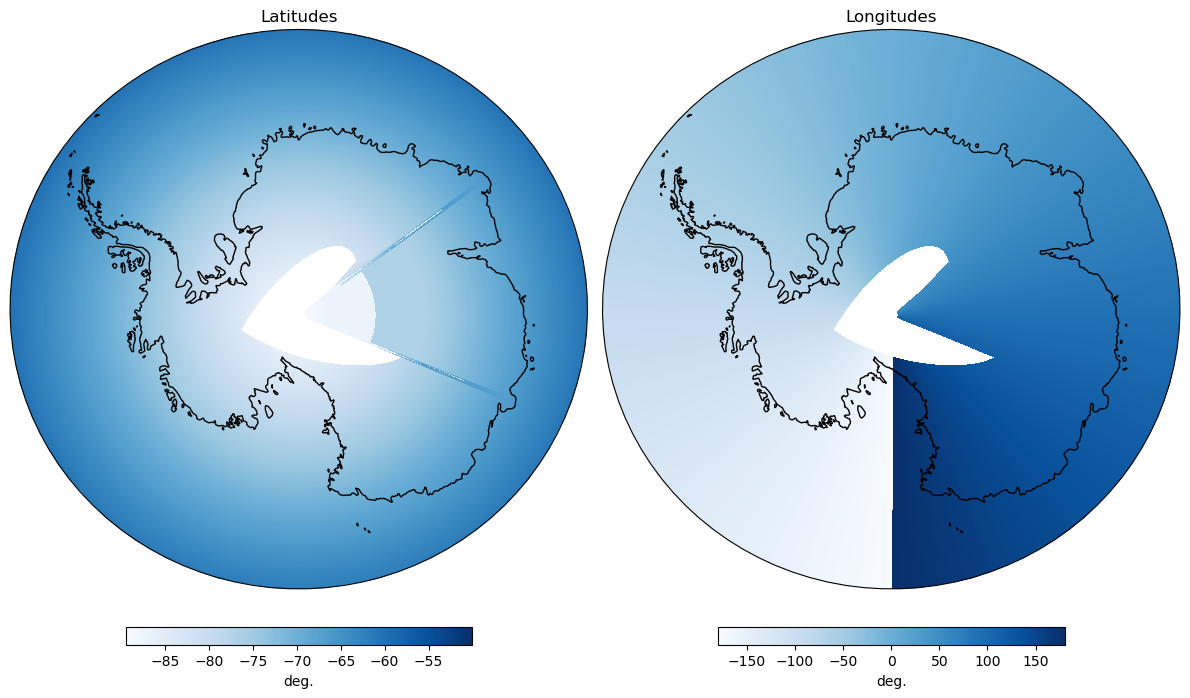

In [4]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(12, 8), layout='tight')

for ax in axes:
    ax.set_extent([160, -150, -90, -60], ccrs.PlateCarree())
    ax.coastlines()
    ax.set_boundary(map_circle, transform=ax.transAxes)

a = axes[0].pcolormesh(mesh.nav_lon, mesh.nav_lat, mesh.gphit.squeeze(), transform=ccrs.PlateCarree(), cmap='Blues')
axes[0].set_title('Latitudes')

b = axes[1].pcolormesh(mesh.nav_lon, mesh.nav_lat, mesh.glamt.squeeze(), transform=ccrs.PlateCarree(), cmap='Blues')
axes[1].set_title('Longitudes')

cbar_a = fig.colorbar(a, ax=axes[0], orientation='horizontal', pad=0.05, shrink=.6)
cbar_a.set_label('deg.')

cbar_b = fig.colorbar(b, ax=axes[1], orientation='horizontal', pad=0.05, shrink=.6)
cbar_b.set_label('deg.')

plt.savefig('plots/meshmask.jpg', dpi=300)

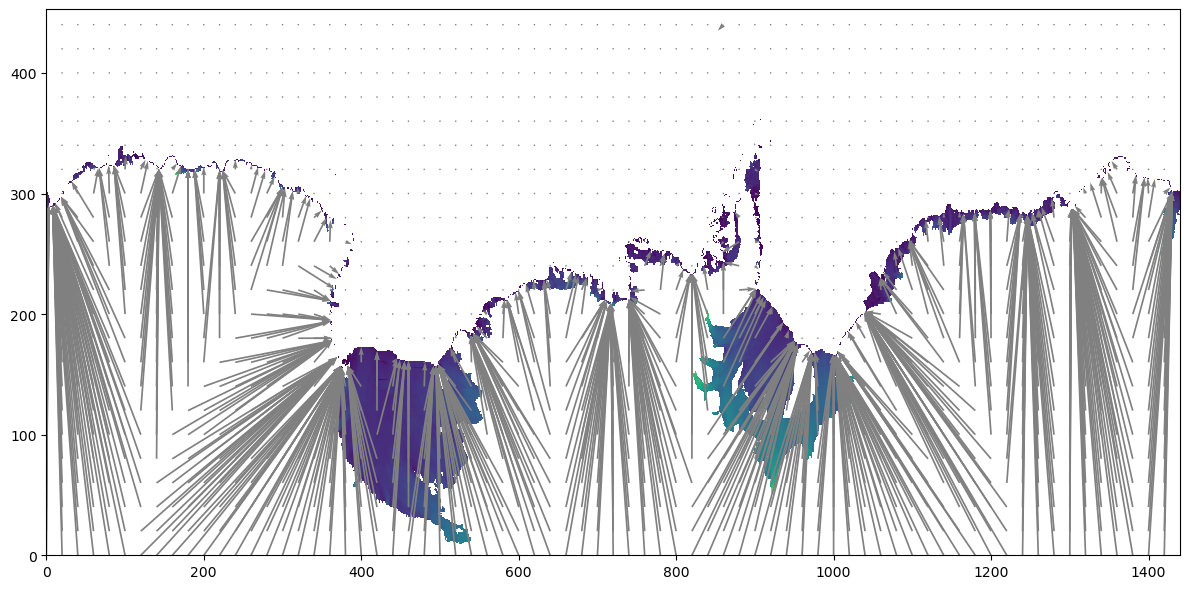

In [5]:
fig, axes = plt.subplots(1,1, figsize=(12, 6), layout='tight')

axes.pcolormesh(dom.isf_draft.where(dom.isf_draft!=0).squeeze())
axes.quiver(mesh.x[::20], mesh.y[::20], route.xindex[::20,::20]-mesh.x[::20], route.yindex[::20,::20]-mesh.y[::20], scale=1, scale_units='xy', angles='xy', color='grey', width=0.0015)

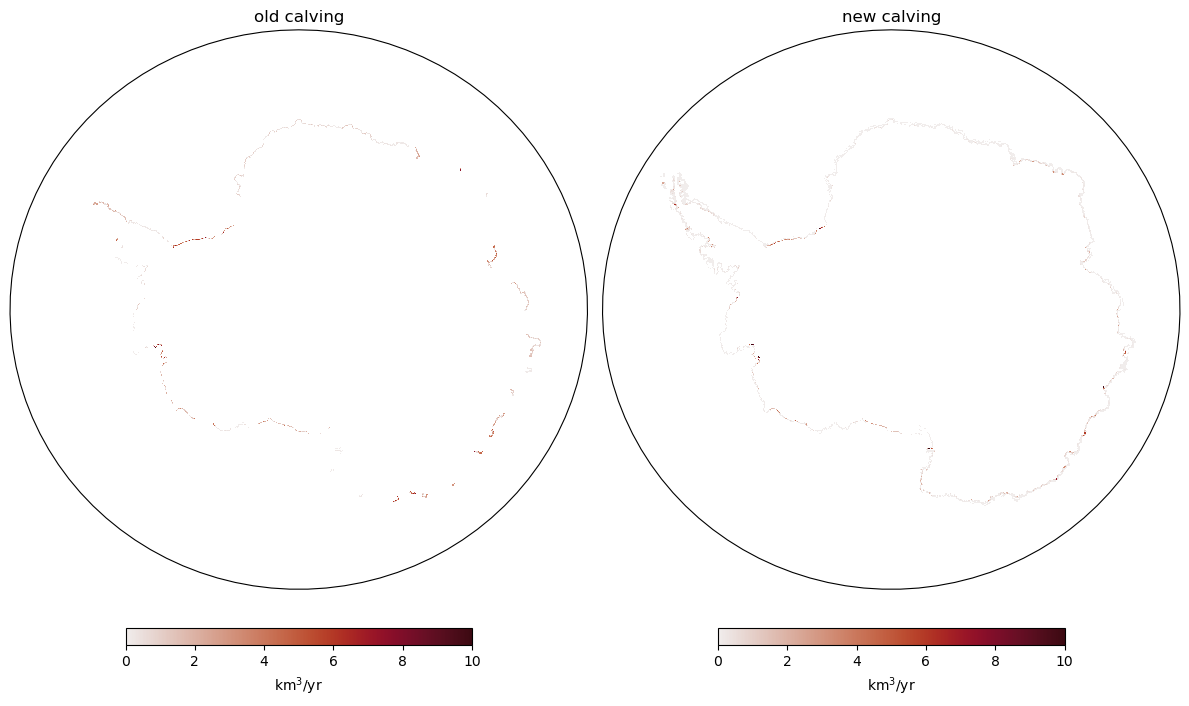

In [6]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(12, 8), layout='tight')

for ax in axes:
    ax.set_extent([160, -150, -90, -60], ccrs.PlateCarree())
#    ax.coastlines()
    ax.set_boundary(map_circle, transform=ax.transAxes)

a = axes[0].pcolormesh(route.lon, route.lat, calv_orig.soicbclv.squeeze(), vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=co.cm.amp)
axes[0].set_title('old calving')

b = axes[1].pcolormesh(route.lon, route.lat, calv_update.soicbclv.squeeze(), vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=co.cm.amp)
axes[1].set_title('new calving')

cbar_a = fig.colorbar(a, ax=axes[0], orientation='horizontal', pad=0.05, shrink=.6)
cbar_a.set_label('km$^3$/yr')

cbar_b = fig.colorbar(b, ax=axes[1], orientation='horizontal', pad=0.05, shrink=.6)
cbar_b.set_label('km$^3$/yr')

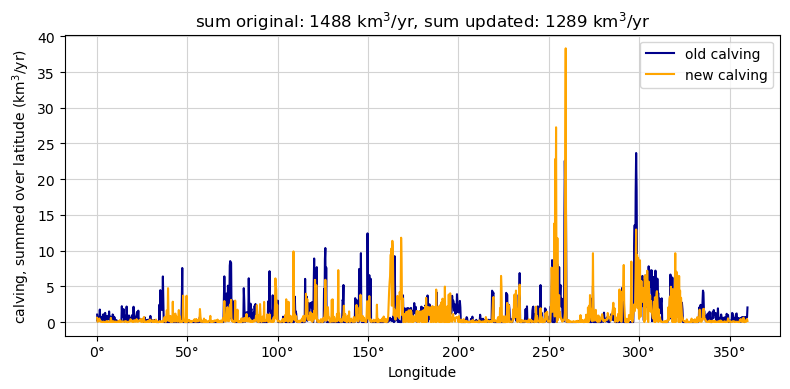

In [7]:
def format_lon(x, pos):
    return f'{x:.0f}°'

lon = route.lon.values
lon_360 = np.where(route.lon[150] < 0, route.lon[150] + 360, route.lon[150])

calv_o = calv_orig.soicbclv.squeeze().sum('y').values
calv_u = calv_update.soicbclv.squeeze().sum('y').values

sorted_indices = np.argsort(lon_360)
lon_sorted = lon_360[sorted_indices]

calv_o_sort = calv_o[sorted_indices]
calv_u_sort = calv_u[sorted_indices]

fig, axes = plt.subplots(1,1, figsize=(8, 4), layout='tight')

axes.plot(lon_sorted, calv_o_sort, c='darkblue', label='old calving')
axes.plot(lon_sorted, calv_u_sort, c='orange', label='new calving')
axes.grid(color='lightgrey')

axes.set_xlabel('Longitude')
axes.set_ylabel('calving, summed over latitude (km$^3$/yr)')
axes.set_title('sum original: 1488 km$^3$/yr, sum updated: 1289 km$^3$/yr')
axes.legend()
axes.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))

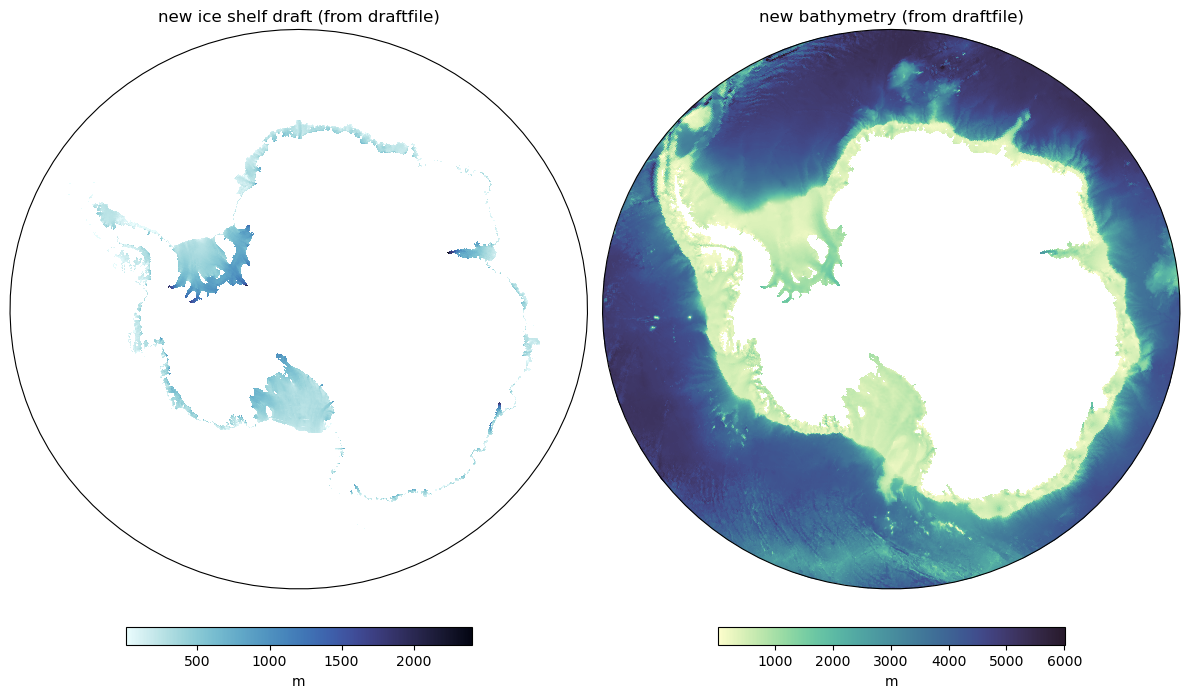

In [8]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(12, 8), layout='tight')

for ax in axes:
    ax.set_extent([160, -150, -90, -60], ccrs.PlateCarree())
    #ax.coastlines()
    ax.set_boundary(map_circle, transform=ax.transAxes)

a = axes[0].pcolormesh(route.lon, route.lat, draft.isf_draft, transform=ccrs.PlateCarree(), cmap=co.cm.ice_r)
axes[0].set_title('new ice shelf draft (from draftfile)')

b = axes[1].pcolormesh(route.lon, route.lat, draft.Bathymetry_isf, transform=ccrs.PlateCarree(), cmap=co.cm.deep)
axes[1].set_title('new bathymetry (from draftfile)')

cbar_a = fig.colorbar(a, ax=axes[0], orientation='horizontal', pad=0.05, shrink=.6)
cbar_a.set_label('m')

cbar_b = fig.colorbar(b, ax=axes[1], orientation='horizontal', pad=0.05, shrink=.6)
cbar_b.set_label('m')

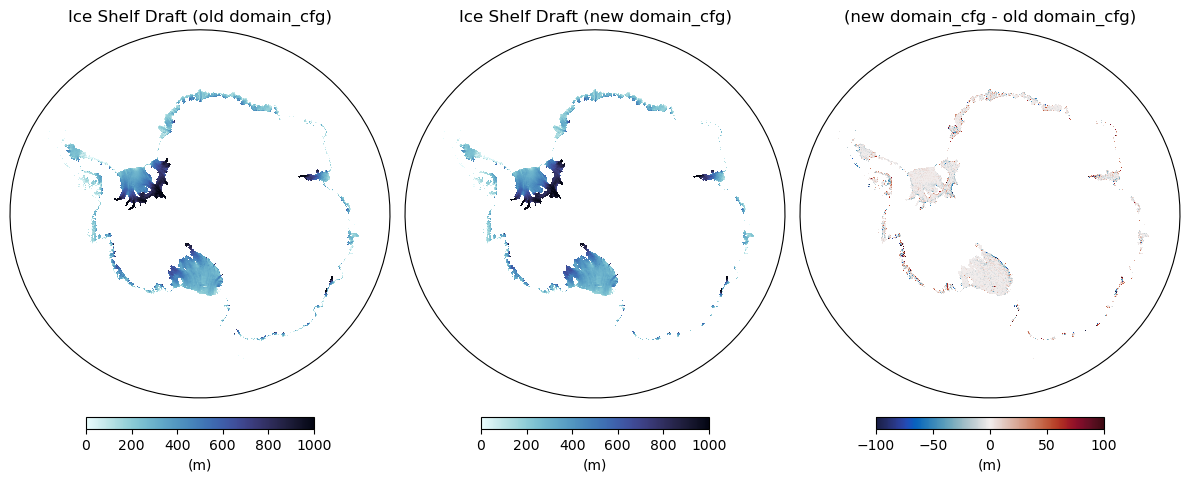

In [9]:
fig, axes = plt.subplots(1,3, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(12, 10), layout='tight')

for ax in axes:
    ax.set_extent([160, -150, -90, -60], ccrs.PlateCarree())
    #ax.coastlines()
    ax.set_boundary(map_circle, transform=ax.transAxes)

a = axes[0].pcolormesh(dom.nav_lon, dom.nav_lat, dom.isf_draft.squeeze(), vmin=0, vmax=1000, transform=ccrs.PlateCarree(), cmap=co.cm.ice_r)
axes[0].set_title('Ice Shelf Draft (old domain_cfg)')

b = axes[1].pcolormesh(dom.nav_lon, dom.nav_lat, dom_newisf.isf_draft.squeeze(), vmin=0, vmax=1000, transform=ccrs.PlateCarree(), cmap=co.cm.ice_r)
axes[1].set_title('Ice Shelf Draft (new domain_cfg)')

c = axes[2].pcolormesh(dom.nav_lon, dom.nav_lat, (dom_newisf.isf_draft-dom.isf_draft).squeeze(), vmin=-100, vmax=100, transform=ccrs.PlateCarree(), cmap=co.cm.balance)
axes[2].set_title('(new domain_cfg - old domain_cfg)')

cbar_a = fig.colorbar(a, ax=axes[0], orientation='horizontal', pad=0.02, shrink=.6)
cbar_a.set_label('(m)')

cbar_b = fig.colorbar(b, ax=axes[1], orientation='horizontal', pad=0.02, shrink=.6)
cbar_b.set_label('(m)')

cbar_c = fig.colorbar(c, ax=axes[2], orientation='horizontal', pad=0.02, shrink=.6)
cbar_c.set_label('(m)');

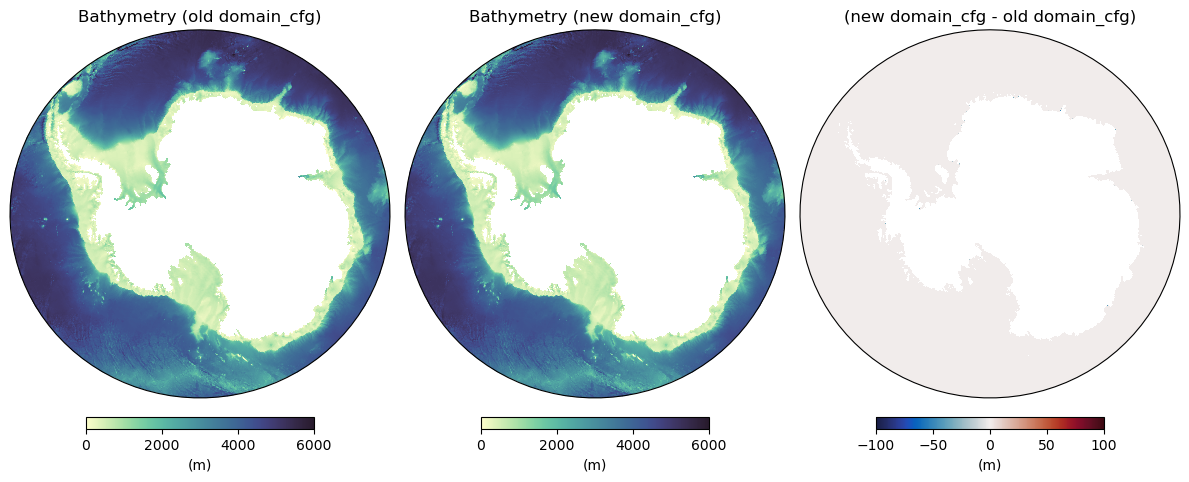

In [10]:
fig, axes = plt.subplots(1,3, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(12, 10), layout='tight')

for ax in axes:
    ax.set_extent([160, -150, -90, -60], ccrs.PlateCarree())
    #ax.coastlines()
    ax.set_boundary(map_circle, transform=ax.transAxes)

a = axes[0].pcolormesh(dom.nav_lon, dom.nav_lat, dom.bathy_metry.squeeze(), vmin=0, vmax=6000, transform=ccrs.PlateCarree(), cmap=co.cm.deep)
axes[0].set_title('Bathymetry (old domain_cfg)')

b = axes[1].pcolormesh(dom.nav_lon, dom.nav_lat, dom_newisf.bathy_metry.squeeze(), vmin=0, vmax=6000, transform=ccrs.PlateCarree(), cmap=co.cm.deep)
axes[1].set_title('Bathymetry (new domain_cfg)')

c = axes[2].pcolormesh(dom.nav_lon, dom.nav_lat, (dom_newisf.bathy_metry-dom.bathy_metry).squeeze(), vmin=-100, vmax=100, transform=ccrs.PlateCarree(), cmap=co.cm.balance)
axes[2].set_title('(new domain_cfg - old domain_cfg)')

cbar_a = fig.colorbar(a, ax=axes[0], orientation='horizontal', pad=0.02, shrink=.6)
cbar_a.set_label('(m)')

cbar_b = fig.colorbar(b, ax=axes[1], orientation='horizontal', pad=0.02, shrink=.6)
cbar_b.set_label('(m)')

cbar_c = fig.colorbar(c, ax=axes[2], orientation='horizontal', pad=0.02, shrink=.6)
cbar_c.set_label('(m)');

In [11]:
bt = xr.open_dataset()

TypeError: open_dataset() missing 1 required positional argument: 'filename_or_obj'